- Most/least responsive cells
- Most/least impactrul (damaging) drugs

- Most/least predictive cells (lowest error)
- Most/least predictive drugs (lowest error)

------------

- Encode count of cells/drugs
- Separate results by study

------------

- https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial
- https://seaborn.pydata.org/tutorial/distributions.html#distribution-tutorial

From Rick:

1. Look at the FP data from a cancer type (agg stats for all cell Lines in a given cancer type), cell line, drug, and drug class perspectives.
2. Are some {studies, cell lines, drugs, drug class, cancer type} harder than others to predict correctly?
3. If we filter out samples with poor AUC fits do the predictions improve (they should but we should characterize the level of improvement).
4. Ideally we want to set some quality thresholds that can be applied to experimental results to improve training.
5. AUC fit is a good one --> (ap) Is this a question?
6. Test the suggested that we exclude the middle values from training (but not from validation) and see if that improves things.

Addressing requests:
1. False predictions from different perspectives. By: cancer type, cell line, drug, drug class.
   - (A) Parplots or boxplots of the most falsely predictable items (have similar plots)
2. Are some (studies, cell lines, drugs, drug class, cancer type) harder than others to predict correctly?
   - (NA) Directly falls from part (1)
3. If we drop samples with poor AUC fits, do the predictions improve? They should but we should characterize the level of improvement.
   - (A) Plot histogram of R2fit values
   - (A) Plot of scores vs minimum R2fit in the dataset (requires to train multiple runs).
     For each tick in R2fit specify the fraction of sample size as compared to the original dataset.
4. Ideally we want to set some quality thresholds that can be applied to experimental results to improve training.
   - (NA) Conclusion from part (3).
5. AUC fit is a good one --> (ap) Is this a question?
   - (?) None sure
6. Test the suggested that we exclude the middle values from training (but not from validation) and see if that improves things.
   - (A) Plot histogram of AUC values
   - (A) Plot histogram of AUC values for each of the following: FP, FN, TP, TN

In [1]:
!which python

/Users/apartin/anaconda3/envs/p1_mac/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay  # error

TO_PLOT = False

In [3]:
# runs_dir_name = 'out_lgbm'
# runs_dir_name = 'out_lgbm_cls'
# runs_dir_name = 'out_lgbm_cls_811_v1'

runs_dir_name = 'out_cls_r0'
# runs_dir_name = 'out_cls_r10'
file_path = Path.cwd()
print(file_path)

# mltype = 'reg'
mltype = 'cls'

out_postproc_fpath = file_path/'..'/runs_dir_name/'post_proc'
os.makedirs(out_postproc_fpath, exist_ok=True)

# out_figs = file_path / 'out_figs_cls'
# os.makedirs(out_figs, exist_ok=True)

runs_dir_path = Path(file_path / '..' / runs_dir_name)
runs_dirs = [Path(p) for p in glob(str(runs_dir_path/'run_*'))]
# pred = pd.read_csv(os.path.join(predsdir, 'dev_lgb_reg_preds.csv'))

/Users/apartin/Box Sync/projects/DrugResponseViz/notebooks


In [4]:
out_postproc_fpath

PosixPath('/Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_cls_r0/post_proc')

In [5]:
# Load cell metadata
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
print(cancer_types.shape)
display(cancer_types[:2])

# cmeta = pd.read_csv(file_path/'../data/combined_metadata_2018May.txt', sep='\t')
# print(cmeta.shape)

# dmeta = pd.read_csv(file_path/'../data/drug_info', sep='\t')
# print(dmeta.shape)

(14590, 2)


,CELL,CTYPE
0,CCLE.ALLSIL,Acute_Lymphoblastic_Leukemia
1,CCLE.DND41,Acute_Lymphoblastic_Leukemia


In [6]:
def plot_target(data_to_plot, y_name, x_name, kind='box', hue_name=None, height=None, aspect=None):
    """ Plot function. """
    if hue_name:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, hue=hue_name, **args);
    else:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, **args);
    return g

# Aggregate predictions from all runs (shuffles/splits)

In [7]:
def reorg_cols(df, col_first:str):
    """
    Args:
        col_first : col name to put first
    """
    cols = df.columns.tolist()
    cols.remove(col_first)
    return df[[col_first] + cols]
    
def agg_preds_from_cls_runs(runs_dirs, phase='_te.csv', verbose=False):
    """ Aggregate predictions bootstraped ML trainings. """
    prd = []
    for i, dir_name in enumerate(runs_dirs):
        if '_tr.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_tr.csv')
        elif '_vl.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_vl.csv')
        elif '_te.csv' in phase:
            prd_ = pd.read_csv(dir_name/'preds_te.csv')
        
        # prd_te_['err'] = abs(prd_te_['y_true'] - prd_te_['y_pred'])      # add col 'err'
        prd_['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]  # add col 'run' identifier
        prd.append(prd_)  # append run data

        if verbose:
            if i%20==0:
                print(f'Processing {dir_name}')
            
    # Aggregate to df
    prd = pd.concat(prd, axis=0)
    
    # Reorganize cols
    prd = reorg_cols(prd, col_first='run').sort_values('run').reset_index(drop=True).reset_index().rename(columns={'index': 'idx'})
    return prd

In [8]:
# Concat preds from all runs      
prd_te_all = agg_preds_from_cls_runs(runs_dirs, phase='_te.csv')
prd_te_all.insert(loc=2, column='source', value=[s.split('.')[0].lower() for s in prd_te_all['CELL']]) # add 'source' column

print(prd_te_all.shape)
display(prd_te_all[:2])

# Add CTYPE columns
prd_te_all = pd.merge(prd_te_all, cancer_types, on='CELL')
prd_te_all = reorg_cols(prd_te_all, col_first='CTYPE')
display( prd_te_all[:2] )

(3691900, 8)


,idx,run,source,CELL,DRUG,AUC,y_true,y_pred
0,0,s000,ctrp,CTRP.ESS-1,CTRP.445,0.9245,0,0.001339
1,1,s000,ctrp,CTRP.HD-MY-Z,CTRP.182,0.4161,1,0.580708


,CTYPE,idx,run,source,CELL,DRUG,AUC,y_true,y_pred
0,Uterine_Corpus_Endometrial_Carcinoma,0,s000,ctrp,CTRP.ESS-1,CTRP.445,0.9245,0,0.001339
1,Uterine_Corpus_Endometrial_Carcinoma,32,s000,ctrp,CTRP.ESS-1,CTRP.147,0.9428,0,0.020743


In [9]:
# Plot confusion matrix
y_true_cls = prd_te_all.y_true
y_pred_cls = prd_te_all.y_pred.map(lambda x: 0 if x<0.5 else 1)
np_conf = confusion_matrix(y_true_cls, y_pred_cls)
tn, fp, fn, tp = confusion_matrix(y_true_cls, y_pred_cls).ravel()

mcc = sklearn.metrics.matthews_corrcoef(y_true_cls, y_pred_cls, sample_weight=None)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)
print('FPR:', fp/(fp+tn))
print('FNR:', fn/(fn+tp))
print('MCC:', mcc)

with open(out_postproc_fpath/'scores.txt', 'w') as f:
    f.write('TN: {:d}\n'.format(tn))
    f.write('TN: {:d}\n'.format(tn))
    f.write('FP: {:d}\n'.format(fp))
    f.write('FN: {:d}\n'.format(fn))
    f.write('TP: {:d}\n'.format(tp))
    f.write('FPR: {:.5f}\n'.format(fp/(fp+tn)))
    f.write('FNR: {:.5f}\n'.format(fn/(fn+tp)))
    f.write('MCC: {:.5f}\n'.format(mcc))

TN: 3539586
FP: 23272
FN: 63969
TP: 65073
FPR: 0.006531834835965957
FNR: 0.49572232296461616
MCC: 0.5981579448220748


In [10]:
# Confusion Matrix
# conf = confusion_matrix(y_true_cls, y_pred_cls, normalize=None)
# conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
# conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='d')
# plt.show()

In [11]:
# Confusion Matrix (normalized)
# conf = confusion_matrix(y_true_cls, y_pred_cls, normalize='all')
# conf_plot = ConfusionMatrixDisplay(conf, display_labels=['NoResp', 'Resp'])
# conf_plot.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation=None, values_format='.2f')
# plt.show()

# Brier Scores

In [12]:
df_brier = prd_te_all.copy()
df_brier['y_pred_cls'] = df_brier.y_pred.map(lambda x: 0 if x<0.5 else 1)
display(df_brier[:2])

tp_df = df_brier[(df_brier.y_true==1) & (df_brier.y_pred_cls==1)]
fn_df = df_brier[(df_brier.y_true==1) & (df_brier.y_pred_cls==0)]
tn_df = df_brier[(df_brier.y_true==0) & (df_brier.y_pred_cls==0)]
fp_df = df_brier[(df_brier.y_true==0) & (df_brier.y_pred_cls==1)]

brier_scores = {}
brier_scores['tp'] = sklearn.metrics.brier_score_loss(tp_df.y_true, tp_df.y_pred)
brier_scores['fn'] = sklearn.metrics.brier_score_loss(fn_df.y_true, fn_df.y_pred)
brier_scores['tn'] = sklearn.metrics.brier_score_loss(tn_df.y_true, tn_df.y_pred)
brier_scores['fp'] = sklearn.metrics.brier_score_loss(fp_df.y_true, fp_df.y_pred)

print(brier_scores)
del df_brier

,CTYPE,idx,run,source,CELL,DRUG,AUC,y_true,y_pred,y_pred_cls
0,Uterine_Corpus_Endometrial_Carcinoma,0,s000,ctrp,CTRP.ESS-1,CTRP.445,0.9245,0,0.001339,0
1,Uterine_Corpus_Endometrial_Carcinoma,32,s000,ctrp,CTRP.ESS-1,CTRP.147,0.9428,0,0.020743,0


{'tp': 0.5422677327087051, 'fn': 0.08142945719044276, 'tn': 0.0026687150353691645, 'fp': 0.42322720686184023}


# Calibrate classification probabilities

- https://gdmarmerola.github.io/probability-calibration/
- https://github.com/Microsoft/LightGBM/issues/1562
- https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv/263411
- https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV

# Create summary table

In [13]:
# TODO: Problem!
# why agg by [CELL, DRUG] works, but agg by [CELL] doesn't work?!
# dff = prd_te_all.groupby(['CELL', 'DRUG']).agg({'y_true': np.unique}).reset_index()  # works
# dff = prd_te_all.groupby(['CELL']).agg({'y_true': np.unique}).reset_index()  # does not work
# dff = prd_te_all.groupby(['CELL']).agg({'y_true': 'unique'}).reset_index()  # works

In [14]:
# Summary table
prd_te_to_grp = prd_te_all.copy()
prd_te_to_grp['y_pred_prob_median'] = prd_te_to_grp.y_pred
prd_te_to_grp['y_pred_prob_std'] = prd_te_to_grp.y_pred
prd_te_to_grp['y_pred_tot'] = prd_te_to_grp.idx
prd_te_to_grp['y_pred_cls_0'] = prd_te_to_grp.y_pred.map(lambda x: True if x<0.5 else False)
prd_te_to_grp['y_pred_cls_1'] = prd_te_to_grp.y_pred.map(lambda x: True if x>=0.5 else False)
prd_te_to_grp['y_true_unq_vals'] = prd_te_to_grp.y_true

# Cell-wise analysis

In [15]:
def add_conf_data(data):
    """ Add columns are used to calc confusion matrix TP, TN, FN, FP. """
    data['TP'] = data.apply(lambda row: row.y_pred_cls_1 if row.y_true==1 else False, axis=1)  # tp
    data['TN'] = data.apply(lambda row: row.y_pred_cls_0 if row.y_true==0 else False, axis=1)  # tn
    data['FN'] = data.apply(lambda row: row.y_pred_cls_0 if row.y_true==1 else False, axis=1)  # fn
    data['FP'] = data.apply(lambda row: row.y_pred_cls_1 if row.y_true==0 else False, axis=1)  # fp
    
    data['TPR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.TP / (row.TP + row.FN), axis=1)  # sensitivity, recall: TP/P = TP/(TP+FN)
    data['TNR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.TN / (row.TN + row.FP), axis=1)  # specificity: TN/N = TN/(TN+FP)
    
    data['FPR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.FP / (row.TN + row.FP), axis=1)  # fall-out: FP/N = FP/(FP+TN)
    data['FNR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.FN / (row.TP + row.FN), axis=1)  # miss-rate: FN/NP = FN/(FN+TP)
    
    # data['TPR'] = data['TP'].values / (data['TP'].values + data['FN'].values)  # sensitivity, recall
    # data['TNR'] = data['TN'].values / (data['TN'].values + data['FP'].values)  # specificity
    return data

In [16]:
n_show = 4
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']
def print_sorted_grouped_df(df, cols, n_show=4):
    print('\nSorted by FN and FNR')
    display( df[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FN and Total Preds')
    display( df[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FP and FPR')
    display( df[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )

    print('\nSorted by FP and Total Preds')
    display( df[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )

In [17]:
# Groupby sample (cell)
# Note blyat! np.unique does BOT work!
# sm_cell = prd_te_to_grp.groupby(['CELL']).agg(

by = 'CELL'
sm_cell = prd_te_to_grp.groupby([by, 'y_true']).agg(    
    {'DRUG': 'unique',
     'CTYPE': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

# sm_cell = reorg_cols(sm_cell, col_first='CTYPE')
sm_cell['y_true_unq_vals'] = sm_cell.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
# display(sm_cell[:2])

sm_cell = add_conf_data(sm_cell)
display(sm_cell[:2])

,CELL,y_true,DRUG,CTYPE,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,CCLE.42MGBA,0,"[CCLE.23, CCLE.5, CCLE.12, CCLE.24, CCLE.1, CC...",[Glioblastoma_Multiforme],1,0.002409,0.036697,173,0,173,False,173,False,0,NaN,1.0,0.0,NaN
1,CCLE.42MGBA,1,"[CCLE.18, CCLE.14, CCLE.11, CCLE.3]",[Glioblastoma_Multiforme],1,0.460800,0.247615,21,18,39,18,False,21,False,0.461538,NaN,NaN,0.538462


In [18]:
n_show = 10
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']

print('\nSorted by FN and FNR')
display( sm_cell[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )
"""
New run:
CTRP.AM-38
NCI60.A498
NCI60.NCI-H522
NCI60.MALME-3M
"""


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Glioblastoma_Multiforme],CTRP.AM-38,"[CTRP.530, CTRP.112, CTRP.2, CTRP.526, CTRP.72...",0.097757,500,151,False,349,False,0.302000,NaN,NaN,0.698000
1,[Kidney_Renal_Clear_Cell_Carcinoma],NCI60.A498,"[NSC.764334, NSC.772563, NSC.764658, NSC.76119...",0.139146,396,83,False,313,False,0.209596,NaN,NaN,0.790404
2,[Lung_Adenocarcinoma],NCI60.NCI-H522,"[NSC.256439, NSC.768072, NSC.747973, NSC.26653...",0.290333,356,114,False,242,False,0.320225,NaN,NaN,0.679775
3,[Skin_Cutaneous_Melanoma],NCI60.MALME-3M,"[NSC.24559, NSC.747973, NSC.266535, NSC.733504...",0.205386,297,68,False,229,False,0.228956,NaN,NaN,0.771044
4,[Lymphoid_Leukemia],CTRP.SEM,"[CTRP.519, CTRP.219, CTRP.233, CTRP.542, CTRP....",0.692198,525,310,False,215,False,0.590476,NaN,NaN,0.409524
5,[Skin_Cutaneous_Melanoma],NCI60.MDA-MB-435,"[NSC.700893, NSC.768072, NSC.381866, NSC.77844...",0.349442,345,131,False,214,False,0.379710,NaN,NaN,0.620290
6,[Skin_Cutaneous_Melanoma],NCI60.SK-MEL-5,"[NSC.761190, NSC.778448, NSC.67574, NSC.758254...",0.263141,312,100,False,212,False,0.320513,NaN,NaN,0.679487
7,[Colon_Adenocarcinoma],NCI60.COLO205,"[NSC.778448, NSC.759657, NSC.649890, NSC.74797...",0.143162,274,64,False,210,False,0.233577,NaN,NaN,0.766423
8,[Lymphoid_Leukemia],GDSC.SR,"[GDSC.201, GDSC.11, GDSC.1248, GDSC.104, GDSC....",0.442345,384,183,False,201,False,0.476562,NaN,NaN,0.523438
9,[Acute_Myeloid_Leukemia],CTRP.KASUMI-1,"[CTRP.512, CTRP.38, CTRP.282, CTRP.28, CTRP.45...",0.518771,404,207,False,197,False,0.512376,NaN,NaN,0.487624


'\nNew run:\nCTRP.AM-38\nNCI60.A498\nNCI60.NCI-H522\nNCI60.MALME-3M\n'

In [19]:
print('\nSorted by FN and Total Preds')
display( sm_cell[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
CTRP.ZR-75-30
CTRP.Hs-888-T
GDSC.A704
CTRP.SK-MEL-24
GDSC.CFPAC-1
"""


Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Breast_Invasive_Carcinoma],CTRP.ZR-75-30,"[CTRP.376, CTRP.3, CTRP.436, CTRP.386, CTRP.45]",0.017264,60,0,False,60,False,0.0,NaN,NaN,1.0
1,[Sarcoma],CTRP.Hs-888-T,"[CTRP.388, CTRP.3, CTRP.324, CTRP.146, CTRP.326]",0.070774,51,0,False,51,False,0.0,NaN,NaN,1.0
2,[Kidney_Renal_Clear_Cell_Carcinoma],GDSC.A704,"[GDSC.56, GDSC.51, GDSC.1031, GDSC.182, GDSC.1...",0.052928,49,0,False,49,False,0.0,NaN,NaN,1.0
3,[Skin_Cutaneous_Melanoma],CTRP.SK-MEL-24,"[CTRP.446, CTRP.424, CTRP.251, CTRP.385, CTRP....",0.022198,47,0,False,47,False,0.0,NaN,NaN,1.0
4,[Pancreatic_Adenocarcinoma],GDSC.CFPAC-1,"[GDSC.180, GDSC.194, GDSC.200, GDSC.140, GDSC....",0.269313,46,0,False,46,False,0.0,NaN,NaN,1.0
5,[Kidney_Renal_Clear_Cell_Carcinoma],GDSC.KMRC-20,"[GDSC.1031, GDSC.1007, GDSC.1004, GDSC.153]",0.233296,42,0,False,42,False,0.0,NaN,NaN,1.0
6,[Lung_Adenocarcinoma],GDSC.A549,"[GDSC.1007, GDSC.1372, GDSC.1004, GDSC.1031]",0.272389,41,0,False,41,False,0.0,NaN,NaN,1.0
7,[Breast_Invasive_Carcinoma],GDSC.HCC1395,"[GDSC.1031, GDSC.190, GDSC.140, GDSC.180]",0.349435,41,0,False,41,False,0.0,NaN,NaN,1.0
8,[Breast_Invasive_Carcinoma],GDSC.HCC1937,"[GDSC.1007, GDSC.200, GDSC.1031, GDSC.194, GDS...",0.274563,40,0,False,40,False,0.0,NaN,NaN,1.0
9,[Ovarian_Serous_Cystadenocarcinoma],GDSC.OV-90,"[GDSC.200, GDSC.1016, GDSC.180, GDSC.1031]",0.334882,39,0,False,39,False,0.0,NaN,NaN,1.0


'\nCTRP.ZR-75-30\nCTRP.Hs-888-T\nGDSC.A704\nCTRP.SK-MEL-24\nGDSC.CFPAC-1\n'

In [20]:
print('\nSorted by FP and FPR')
display( sm_cell[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Lymphoid_Leukemia],CTRP.BL-41,"[CTRP.89, CTRP.183, CTRP.398, CTRP.394, CTRP.2...",0.006631,1017,False,846,False,171,NaN,0.831858,0.168142,NaN
1,[Acute_Myeloid_Leukemia],CTRP.MONO-MAC-6,"[CTRP.389, CTRP.303, CTRP.153, CTRP.418, CTRP....",0.003046,2819,False,2672,False,147,NaN,0.947854,0.052146,NaN
2,[Lymphoid_Leukemia],NCI60.SR,"[NSC.733504, NSC.782121, NSC.781469, NSC.75434...",0.004589,7660,False,7526,False,134,NaN,0.982507,0.017493,NaN
3,[Lymphoid_Leukemia],CTRP.RI-1,"[CTRP.118, CTRP.411, CTRP.371, CTRP.539, CTRP....",0.006258,3560,False,3445,False,115,NaN,0.967697,0.032303,NaN
4,[Lymphoid_Leukemia],CTRP.BL-70,"[CTRP.86, CTRP.270, CTRP.53, CTRP.297, CTRP.14...",0.006408,3503,False,3402,False,101,NaN,0.971168,0.028832,NaN
5,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],CTRP.MC116,"[CTRP.175, CTRP.414, CTRP.401, CTRP.107, CTRP....",0.002514,3792,False,3692,False,100,NaN,0.973629,0.026371,NaN
6,[Kidney_Renal_Clear_Cell_Carcinoma],NCI60.A498,"[NSC.646275, NSC.650562, NSC.782310, NSC.71402...",0.004133,8718,False,8618,False,100,NaN,0.988529,0.011471,NaN
7,[Lymphoid_Leukemia],CTRP.SEM,"[CTRP.245, CTRP.377, CTRP.114, CTRP.538, CTRP....",0.008049,3318,False,3223,False,95,NaN,0.971368,0.028632,NaN
8,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],CTRP.Toledo,"[CTRP.158, CTRP.373, CTRP.41, CTRP.29, CTRP.54...",0.001908,2609,False,2515,False,94,NaN,0.963971,0.036029,NaN
9,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],GDSC.WSU-DLCL2,"[GDSC.272, GDSC.1033, GDSC.252, GDSC.309, GDSC...",0.008119,1678,False,1585,False,93,NaN,0.944577,0.055423,NaN


In [21]:
print('\nSorted by FP and Total Preds')
display( sm_cell[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
gCSI.KU812
gCSI.MOLP-8
gCSI.KE-97
gCSI.AM-38
gCSI.NCI-H1155
"""


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,[Lymphoid_Leukemia],CTRP.BL-41,"[CTRP.89, CTRP.183, CTRP.398, CTRP.394, CTRP.2...",0.006631,1017,False,846,False,171,NaN,0.831858,0.168142,NaN
1,[Breast_Invasive_Carcinoma],CCLE.MDAMB157,"[CCLE.15, CCLE.3, CCLE.23, CCLE.9, CCLE.6, CCL...",0.002653,235,False,211,False,24,NaN,0.897872,0.102128,NaN
2,[Colon_Adenocarcinoma],CCLE.T84,"[CCLE.2, CCLE.19, CCLE.8, CCLE.4, CCLE.14, CCL...",0.003487,219,False,197,False,22,NaN,0.899543,0.100457,NaN
3,[Lung_Adenocarcinoma],CCLE.HCC827,"[CCLE.22, CCLE.7, CCLE.20, CCLE.10, CCLE.3, CC...",0.003139,195,False,177,False,18,NaN,0.907692,0.092308,NaN
4,[Skin_Cutaneous_Melanoma],CCLE.WM115,"[CCLE.1, CCLE.7, CCLE.4, CCLE.6, CCLE.18, CCLE...",0.002787,206,False,187,False,19,NaN,0.907767,0.092233,NaN
5,[Lung_Small_Cell_Carcinoma],CCLE.SHP77,"[CCLE.23, CCLE.9, CCLE.10, CCLE.16, CCLE.13, C...",0.003135,222,False,202,False,20,NaN,0.909910,0.090090,NaN
6,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma],CCLE.SUDHL6,"[CCLE.3, CCLE.4, CCLE.2, CCLE.22, CCLE.14, CCL...",0.011164,238,False,218,False,20,NaN,0.915966,0.084034,NaN
7,[Stomach_Adenocarcinoma],CCLE.SNU1,"[CCLE.24, CCLE.19, CCLE.22, CCLE.3, CCLE.9, CC...",0.003740,223,False,206,False,17,NaN,0.923767,0.076233,NaN
8,[Lung_Small_Cell_Carcinoma],CCLE.NCIH1184,"[CCLE.5, CCLE.14, CCLE.8, CCLE.22, CCLE.19, CC...",0.004001,227,False,210,False,17,NaN,0.925110,0.074890,NaN
9,[Esophageal_Carcinoma],CCLE.KYSE180,"[CCLE.19, CCLE.7, CCLE.1, CCLE.24, CCLE.5, CCL...",0.002547,167,False,155,False,12,NaN,0.928144,0.071856,NaN


'\ngCSI.KU812\ngCSI.MOLP-8\ngCSI.KE-97\ngCSI.AM-38\ngCSI.NCI-H1155\n'

# Plot distributions

!! TODO !!

In [22]:
"""
Barplots of FNR or FPR values of cell lines:
- show N cells with the highest value
- include the count
- color code by cancer type
"""

'\nBarplots of FNR or FPR values of cell lines:\n- show N cells with the highest value\n- include the count\n- color code by cancer type\n'

# Cancer-wise analysis

In [23]:
# Groupby Cancer typ
by = 'CTYPE'
sm_ctype = prd_te_to_grp.groupby([by, 'y_true']).agg(    
    {'DRUG': 'unique',
     'CELL': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

# sm_ctype = reorg_cols(sm_ctype, col_first='CTYPE')
sm_ctype['y_true_unq_vals'] = sm_ctype.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
# display(sm_ctype[:2])

sm_ctype = add_conf_data(sm_ctype)
display(sm_ctype[:2])

,CTYPE,y_true,DRUG,CELL,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Acute_Myeloid_Leukemia,0,"[CTRP.360, CTRP.338, CTRP.392, CTRP.193, CTRP....","[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...",1,0.003722,0.104218,99430,1701,101131,False,99430,False,1701,NaN,0.98318,0.01682,NaN
1,Acute_Myeloid_Leukemia,1,"[CTRP.517, CTRP.182, CTRP.363, CTRP.309, CTRP....","[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...",1,0.621833,0.310996,2917,4501,7418,4501,False,2917,False,0.606767,NaN,NaN,0.393233


In [24]:
# Print sorted
print_sorted_grouped_df(sm_ctype, cols=cols, n_show=2)


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.HD-MY-Z, CTRP.KMS-21BM, CTRP.L-540, GDSC...","[CTRP.182, CTRP.235, CTRP.247, CTRP.43, CTRP.3...",0.684921,20036,13445,False,6591,False,0.671042,NaN,NaN,0.328958
1,Lung_Adenocarcinoma,"[CTRP.NCI-H23, CTRP.COR-L105, GDSC.NCI-H1693, ...","[CTRP.247, CTRP.219, CTRP.3, CTRP.259, CTRP.15...",0.426860,9340,3808,False,5532,False,0.407709,NaN,NaN,0.592291



Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Kidney_Renal_Clear_Cell_Carcinoma,"[CTRP.RCC10RGB, NCI60.ACHN, NCI60.SN12C, GDSC....","[CTRP.3, NSC.754143, NSC.768112, NSC.747973, N...",0.257060,2874,655,False,2219,False,0.227905,NaN,NaN,0.772095
1,Ovarian_Serous_Cystadenocarcinoma,"[CTRP.OV7, GDSC.OV-7, NCI60.OVCAR-5, NCI60.OVC...","[CTRP.203, CTRP.159, CTRP.454, CTRP.157, CTRP....",0.372822,3270,1142,False,2128,False,0.349235,NaN,NaN,0.650765



Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.HD-MY-Z, CTRP.KMS-21BM, CTRP.L-540, GDSC...","[CTRP.363, CTRP.129, CTRP.170, CTRP.389, CTRP....",0.003428,254613,False,250772,False,3841,NaN,0.984914,0.015086,NaN
1,Lung_Small_Cell_Carcinoma,"[CTRP.NCI-H446, CTRP.NCI-H1105, CTRP.NCI-H2029...","[CTRP.422, CTRP.61, CTRP.465, CTRP.63, CTRP.25...",0.002109,184770,False,182976,False,1794,NaN,0.990291,0.009709,NaN



Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Acute_Myeloid_Leukemia,"[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...","[CTRP.360, CTRP.338, CTRP.392, CTRP.193, CTRP....",0.003722,101131,False,99430,False,1701,NaN,0.983180,0.016820,NaN
1,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP.OCI-LY3, GDSC.A4-Fuk, CTRP.SU-DHL-6, CTR...","[CTRP.425, CTRP.185, CTRP.246, CTRP.172, CTRP....",0.004508,103510,False,101790,False,1720,NaN,0.983383,0.016617,NaN


In [25]:
n_show = 10
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']

print('\nSorted by FN and FNR')
display( sm_ctype[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )
"""
...
"""


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.HD-MY-Z, CTRP.KMS-21BM, CTRP.L-540, GDSC...","[CTRP.182, CTRP.235, CTRP.247, CTRP.43, CTRP.3...",0.684921,20036,13445,False,6591,False,0.671042,NaN,NaN,0.328958
1,Lung_Adenocarcinoma,"[CTRP.NCI-H23, CTRP.COR-L105, GDSC.NCI-H1693, ...","[CTRP.247, CTRP.219, CTRP.3, CTRP.259, CTRP.15...",0.426860,9340,3808,False,5532,False,0.407709,NaN,NaN,0.592291
2,Skin_Cutaneous_Melanoma,"[CTRP.CJM, CTRP.Hs-936-T, CTRP.WM-983B, CTRP.S...","[CTRP.247, CTRP.43, CTRP.530, CTRP.299, CTRP.1...",0.421391,9094,3730,False,5364,False,0.410161,NaN,NaN,0.589839
3,Colon_Adenocarcinoma,"[GDSC.HCT-116, CTRP.C2BBe1, CTRP.SW620, GDSC.O...","[GDSC.346, GDSC.1372, GDSC.1007, GDSC.208, GDS...",0.403615,7610,2889,False,4721,False,0.379632,NaN,NaN,0.620368
4,Breast_Invasive_Carcinoma,"[NCI60.T-47D, CTRP.CAL-85-1, GDSC.HCC2218, GDS...","[NSC.773095, NSC.681239, NSC.747973, NSC.77572...",0.421337,6759,2696,False,4063,False,0.398876,NaN,NaN,0.601124
5,Lung_Small_Cell_Carcinoma,"[CTRP.NCI-H446, CTRP.NCI-H1105, CTRP.NCI-H2029...","[CTRP.309, CTRP.326, CTRP.3, CTRP.530, CTRP.24...",0.517912,8168,4230,False,3938,False,0.517875,NaN,NaN,0.482125
6,Sarcoma,"[CTRP.SW-1353, CTRP.G-292-clone-A141B1, GDSC.A...","[CTRP.157, CTRP.542, CTRP.3, CTRP.519, CTRP.44...",0.575409,8048,4606,False,3442,False,0.572316,NaN,NaN,0.427684
7,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP.OCI-LY3, GDSC.A4-Fuk, CTRP.SU-DHL-6, CTR...","[CTRP.259, CTRP.293, CTRP.247, CTRP.438, CTRP....",0.697582,9825,6571,False,3254,False,0.668804,NaN,NaN,0.331196
8,Acute_Myeloid_Leukemia,"[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...","[CTRP.517, CTRP.182, CTRP.363, CTRP.309, CTRP....",0.621833,7418,4501,False,2917,False,0.606767,NaN,NaN,0.393233
9,Glioblastoma_Multiforme,"[CTRP.T98G, CTRP.SF295, CTRP.A172, CTRP.CCF-ST...","[CTRP.235, CTRP.132, CTRP.157, CTRP.386, CTRP....",0.409155,4340,1616,False,2724,False,0.372350,NaN,NaN,0.627650


'\n...\n'

In [26]:
print('\nSorted by FN and Total Preds')
display( sm_ctype[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
Lung_NOS
Glioblastoma_Multiforme
Prostate_Adenocarcinoma
"""


Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Kidney_Renal_Clear_Cell_Carcinoma,"[CTRP.RCC10RGB, NCI60.ACHN, NCI60.SN12C, GDSC....","[CTRP.3, NSC.754143, NSC.768112, NSC.747973, N...",0.257060,2874,655,False,2219,False,0.227905,NaN,NaN,0.772095
1,Ovarian_Serous_Cystadenocarcinoma,"[CTRP.OV7, GDSC.OV-7, NCI60.OVCAR-5, NCI60.OVC...","[CTRP.203, CTRP.159, CTRP.454, CTRP.157, CTRP....",0.372822,3270,1142,False,2128,False,0.349235,NaN,NaN,0.650765
2,Glioblastoma_Multiforme,"[CTRP.T98G, CTRP.SF295, CTRP.A172, CTRP.CCF-ST...","[CTRP.235, CTRP.132, CTRP.157, CTRP.386, CTRP....",0.409155,4340,1616,False,2724,False,0.372350,NaN,NaN,0.627650
3,Colon_Adenocarcinoma,"[GDSC.HCT-116, CTRP.C2BBe1, CTRP.SW620, GDSC.O...","[GDSC.346, GDSC.1372, GDSC.1007, GDSC.208, GDS...",0.403615,7610,2889,False,4721,False,0.379632,NaN,NaN,0.620368
4,Breast_Invasive_Carcinoma,"[NCI60.T-47D, CTRP.CAL-85-1, GDSC.HCC2218, GDS...","[NSC.773095, NSC.681239, NSC.747973, NSC.77572...",0.421337,6759,2696,False,4063,False,0.398876,NaN,NaN,0.601124
5,Liver_Hepatocellular_Carcinoma,"[CTRP.SNU-398, CTRP.SNU-761, CTRP.PLC-PRF-5, C...","[CTRP.391, CTRP.189, CTRP.454, CTRP.254, CTRP....",0.416130,2941,1176,False,1765,False,0.399864,NaN,NaN,0.600136
6,Pancreatic_Adenocarcinoma,"[CTRP.BxPC-3, CTRP.CFPAC-1, CTRP.KP-2, CTRP.PA...","[CTRP.223, CTRP.454, CTRP.182, CTRP.363, CTRP....",0.432573,3536,1419,False,2117,False,0.401301,NaN,NaN,0.598699
7,Lung_Adenocarcinoma,"[CTRP.NCI-H23, CTRP.COR-L105, GDSC.NCI-H1693, ...","[CTRP.247, CTRP.219, CTRP.3, CTRP.259, CTRP.15...",0.426860,9340,3808,False,5532,False,0.407709,NaN,NaN,0.592291
8,Skin_Cutaneous_Melanoma,"[CTRP.CJM, CTRP.Hs-936-T, CTRP.WM-983B, CTRP.S...","[CTRP.247, CTRP.43, CTRP.530, CTRP.299, CTRP.1...",0.421391,9094,3730,False,5364,False,0.410161,NaN,NaN,0.589839
9,Lung_Squamous_Cell_Carcinoma,"[GDSC.SK-MES-1, CTRP.LK-2, CTRP.Calu-1, CTRP.L...","[GDSC.200, GDSC.180, GDSC.140, GDSC.201, GDSC....",0.457636,2683,1230,False,1453,False,0.458442,NaN,NaN,0.541558


'\nLung_NOS\nGlioblastoma_Multiforme\nProstate_Adenocarcinoma\n'

In [27]:
print('\nSorted by FP and FPR')
display( sm_ctype[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )
"""
...
"""


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Lymphoid_Leukemia,"[CTRP.HD-MY-Z, CTRP.KMS-21BM, CTRP.L-540, GDSC...","[CTRP.363, CTRP.129, CTRP.170, CTRP.389, CTRP....",0.003428,254613,False,250772,False,3841,NaN,0.984914,0.015086,NaN
1,Lung_Small_Cell_Carcinoma,"[CTRP.NCI-H446, CTRP.NCI-H1105, CTRP.NCI-H2029...","[CTRP.422, CTRP.61, CTRP.465, CTRP.63, CTRP.25...",0.002109,184770,False,182976,False,1794,NaN,0.990291,0.009709,NaN
2,Colon_Adenocarcinoma,"[GDSC.HCT-116, CTRP.C2BBe1, CTRP.SW620, GDSC.O...","[GDSC.1025, GDSC.345, GDSC.1038, GDSC.252, GDS...",0.001668,289061,False,287312,False,1749,NaN,0.993949,0.006051,NaN
3,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP.OCI-LY3, GDSC.A4-Fuk, CTRP.SU-DHL-6, CTR...","[CTRP.425, CTRP.185, CTRP.246, CTRP.172, CTRP....",0.004508,103510,False,101790,False,1720,NaN,0.983383,0.016617,NaN
4,Acute_Myeloid_Leukemia,"[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...","[CTRP.360, CTRP.338, CTRP.392, CTRP.193, CTRP....",0.003722,101131,False,99430,False,1701,NaN,0.983180,0.016820,NaN
5,Skin_Cutaneous_Melanoma,"[CTRP.CJM, CTRP.Hs-936-T, CTRP.WM-983B, CTRP.S...","[CTRP.263, CTRP.192, CTRP.225, CTRP.404, CTRP....",0.001788,326538,False,324873,False,1665,NaN,0.994901,0.005099,NaN
6,Lung_Adenocarcinoma,"[CTRP.NCI-H23, CTRP.COR-L105, GDSC.NCI-H1693, ...","[CTRP.197, CTRP.21, CTRP.34, CTRP.153, CTRP.31...",0.001497,350923,False,349458,False,1465,NaN,0.995825,0.004175,NaN
7,Breast_Invasive_Carcinoma,"[NCI60.T-47D, CTRP.CAL-85-1, GDSC.HCC2218, GDS...","[NSC.763931, NSC.779407, NSC.771858, NSC.76044...",0.001558,256050,False,254887,False,1163,NaN,0.995458,0.004542,NaN
8,Sarcoma,"[CTRP.SW-1353, CTRP.G-292-clone-A141B1, GDSC.A...","[CTRP.183, CTRP.496, CTRP.43, CTRP.499, CTRP.2...",0.002271,166172,False,165068,False,1104,NaN,0.993356,0.006644,NaN
9,Glioblastoma_Multiforme,"[CTRP.T98G, CTRP.SF295, CTRP.A172, CTRP.CCF-ST...","[CTRP.398, CTRP.462, CTRP.433, CTRP.214, CTRP....",0.001606,142521,False,141708,False,813,NaN,0.994296,0.005704,NaN


'\n...\n'

In [28]:
print('\nSorted by FP and Total Preds')
display( sm_ctype[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
...
"""


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,Acute_Myeloid_Leukemia,"[CTRP.PL-21, NCI60.HL-60, GDSC.CMK, GDSC.KG-1,...","[CTRP.360, CTRP.338, CTRP.392, CTRP.193, CTRP....",0.003722,101131,False,99430,False,1701,NaN,0.983180,0.016820,NaN
1,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,"[CTRP.OCI-LY3, GDSC.A4-Fuk, CTRP.SU-DHL-6, CTR...","[CTRP.425, CTRP.185, CTRP.246, CTRP.172, CTRP....",0.004508,103510,False,101790,False,1720,NaN,0.983383,0.016617,NaN
2,Lymphoid_Leukemia,"[CTRP.HD-MY-Z, CTRP.KMS-21BM, CTRP.L-540, GDSC...","[CTRP.363, CTRP.129, CTRP.170, CTRP.389, CTRP....",0.003428,254613,False,250772,False,3841,NaN,0.984914,0.015086,NaN
3,Lung_Small_Cell_Carcinoma,"[CTRP.NCI-H446, CTRP.NCI-H1105, CTRP.NCI-H2029...","[CTRP.422, CTRP.61, CTRP.465, CTRP.63, CTRP.25...",0.002109,184770,False,182976,False,1794,NaN,0.990291,0.009709,NaN
4,Sarcoma,"[CTRP.SW-1353, CTRP.G-292-clone-A141B1, GDSC.A...","[CTRP.183, CTRP.496, CTRP.43, CTRP.499, CTRP.2...",0.002271,166172,False,165068,False,1104,NaN,0.993356,0.006644,NaN
5,Stomach_Adenocarcinoma,"[GDSC.IM-95, CTRP.ECC10, CTRP.Hs-746T, CTRP.SN...","[GDSC.153, GDSC.330, GDSC.346, GDSC.287, GDSC....",0.001906,106891,False,106223,False,668,NaN,0.993751,0.006249,NaN
6,Colon_Adenocarcinoma,"[GDSC.HCT-116, CTRP.C2BBe1, CTRP.SW620, GDSC.O...","[GDSC.1025, GDSC.345, GDSC.1038, GDSC.252, GDS...",0.001668,289061,False,287312,False,1749,NaN,0.993949,0.006051,NaN
7,Uterine_Corpus_Endometrial_Carcinoma,"[CTRP.ESS-1, GDSC.SNG-M, CTRP.JHUEM-1, CTRP.EF...","[CTRP.445, CTRP.147, CTRP.11, CTRP.66, CTRP.15...",0.001651,121134,False,120431,False,703,NaN,0.994197,0.005803,NaN
8,Glioblastoma_Multiforme,"[CTRP.T98G, CTRP.SF295, CTRP.A172, CTRP.CCF-ST...","[CTRP.398, CTRP.462, CTRP.433, CTRP.214, CTRP....",0.001606,142521,False,141708,False,813,NaN,0.994296,0.005704,NaN
9,Esophageal_Carcinoma,"[CTRP.OE33, CTRP.TE-9, CTRP.TE-5, CTRP.COLO-68...","[CTRP.94, CTRP.295, CTRP.210, CTRP.393, CTRP.3...",0.001718,129575,False,128874,False,701,NaN,0.994590,0.005410,NaN


'\n...\n'

# Drug-wise analysis

In [29]:
# Groupby Drug
by = 'DRUG'
sm_drug = prd_te_to_grp.groupby([by, 'y_true']).agg(    
    {# 'DRUG': 'unique',
     'CTYPE': 'unique',
     'CELL': 'unique',
     'y_true_unq_vals': 'unique',
     'y_pred_prob_median': np.median,
     'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)),
     'y_pred_cls_1': lambda x: int(sum(x)),
     'y_pred_tot': lambda x: len(np.unique(x)),
     }).reset_index().sort_values(by, ascending=True)

# sm_ctype = reorg_cols(sm_ctype, col_first='CTYPE')
sm_drug['y_true_unq_vals'] = sm_drug.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
# display(sm_drug[:2])

sm_drug = add_conf_data(sm_drug)
display(sm_drug[:2])

,DRUG,y_true,CTYPE,CELL,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,CCLE.1,0,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lympho...,"[CCLE.PFEIFFER, CCLE.ZR751, CCLE.JHH6, CCLE.CA...",1,0.001060,0.001621,3769,0,3769,False,3769,False,0,NaN,1.0,0.0,NaN
1,CCLE.10,0,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lympho...,"[CCLE.PFEIFFER, CCLE.ZR751, CCLE.JHH6, CCLE.CA...",1,0.001422,0.008596,3670,0,3670,False,3670,False,0,NaN,1.0,0.0,NaN


In [30]:
# Print sorted
print_sorted_grouped_df(sm_drug, cols=cols, n_show=2)


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Colon_Adenocarcinoma, Uterine_Corpus_Endometr...","[GDSC.HCT-116, GDSC.SNG-M, GDSC.IM-95, GDSC.BH...",GDSC.283,0.37918,1995,583,False,1412,False,0.292231,NaN,NaN,0.707769
1,"[Lymphoid_Leukemia, Ovarian_Serous_Cystadenoca...","[CTRP.HD-MY-Z, CTRP.OV7, CTRP.NCI-H23, CTRP.NC...",CTRP.3,0.40970,2156,845,False,1311,False,0.391929,NaN,NaN,0.608071



Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Acute_Myeloid_Leukemia, Sarcoma, Skin_Cutaneo...","[CTRP.PL-21, CTRP.A673, CTRP.SH-4, CTRP.Hs-611...",CTRP.455,0.066040,206,0,False,206,False,0.0,NaN,NaN,1.0
1,"[Acute_Myeloid_Leukemia, Skin_Cutaneous_Melano...","[GDSC.MOLM-13, GDSC.C32, GDSC.OCI-AML2, GDSC.S...",GDSC.1242,0.039299,186,0,False,186,False,0.0,NaN,NaN,1.0



Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Skin_Cutaneous_Melanoma, Glioblastoma_Multifo...","[CTRP.CJM, CTRP.T98G, CTRP.RCC10RGB, CTRP.TE-9...",CTRP.542,0.610812,1592,False,329,False,1263,NaN,0.206658,0.793342,NaN
1,"[Glioblastoma_Multiforme, Skin_Cutaneous_Melan...","[CTRP.T98G, CTRP.WM-983B, CTRP.RCC10RGB, CTRP....",CTRP.309,0.554280,1647,False,602,False,1045,NaN,0.365513,0.634487,NaN



Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Lung_Small_Cell_Carcinoma, Head_and_Neck_Squa...","[GDSC.NCI-H1876, GDSC.NCI-H2171, GDSC.SCC-15, ...",GDSC.104,0.801865,88,False,3,False,85,NaN,0.034091,0.965909,NaN
1,"[Ovarian_Serous_Cystadenocarcinoma, Skin_Cutan...","[NCI60.OVCAR-5, NCI60.M14, NCI60.NCI-ADR-RES, ...",NSC.681239,0.686686,201,False,8,False,193,NaN,0.039801,0.960199,NaN


In [31]:
n_show = 10
cols = ['CTYPE', 'CELL', 'DRUG', 'y_pred_prob_median', 'y_pred_tot', 'TP', 'TN', 'FN', 'FP', 'TPR', 'TNR', 'FPR', 'FNR']

print('\nSorted by FN and FNR')
display( sm_drug[cols].sort_values(['FN', 'FNR'], ascending=False)[:n_show].reset_index(drop=True) )
"""
...
"""


Sorted by FN and FNR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Colon_Adenocarcinoma, Uterine_Corpus_Endometr...","[GDSC.HCT-116, GDSC.SNG-M, GDSC.IM-95, GDSC.BH...",GDSC.283,0.379180,1995,583,False,1412,False,0.292231,NaN,NaN,0.707769
1,"[Lymphoid_Leukemia, Ovarian_Serous_Cystadenoca...","[CTRP.HD-MY-Z, CTRP.OV7, CTRP.NCI-H23, CTRP.NC...",CTRP.3,0.409700,2156,845,False,1311,False,0.391929,NaN,NaN,0.608071
2,"[Uterine_Corpus_Endometrial_Carcinoma, Stomach...","[GDSC.SNG-M, GDSC.IM-95, GDSC.A4-Fuk, GDSC.BHY...",GDSC.194,0.490910,2362,1129,False,1233,False,0.477985,NaN,NaN,0.522015
3,"[Lung_Non-Small_Cell_Carcinoma, Skin_Cutaneous...","[CTRP.LCLC-97TM1, CTRP.CJM, CTRP.T98G, CTRP.OC...",CTRP.386,0.352929,1782,556,False,1226,False,0.312009,NaN,NaN,0.687991
4,"[Uterine_Corpus_Endometrial_Carcinoma, Lymphoi...","[CTRP.ESS-1, CTRP.HD-MY-Z, CTRP.OV7, CTRP.NCI-...",CTRP.235,0.468281,2283,1061,False,1222,False,0.464739,NaN,NaN,0.535261
5,"[Uterine_Corpus_Endometrial_Carcinoma, Lymphoi...","[CTRP.ESS-1, CTRP.HD-MY-Z, CTRP.OV7, CTRP.NCI-...",CTRP.247,0.500663,2383,1192,False,1191,False,0.500210,NaN,NaN,0.499790
6,"[Ovarian_Serous_Cystadenocarcinoma, Lung_Adeno...","[GDSC.OV-7, GDSC.NCI-H1693, GDSC.OUMS-23, GDSC...",GDSC.1031,0.496034,2305,1123,False,1182,False,0.487202,NaN,NaN,0.512798
7,"[Lymphoid_Leukemia, Lung_Non-Small_Cell_Carcin...","[CTRP.HD-MY-Z, CTRP.LCLC-97TM1, CTRP.OV7, CTRP...",CTRP.43,0.566613,2541,1394,False,1147,False,0.548603,NaN,NaN,0.451397
8,"[Colon_Adenocarcinoma, Uterine_Corpus_Endometr...","[GDSC.HCT-116, GDSC.SNG-M, GDSC.IM-95, GDSC.A4...",GDSC.140,0.561090,2621,1594,False,1027,False,0.608165,NaN,NaN,0.391835
9,"[Colon_Adenocarcinoma, Head_and_Neck_Squamous_...","[GDSC.HCT-116, GDSC.BHY, GDSC.HCC2998, GDSC.DM...",GDSC.346,0.339295,1573,556,False,1017,False,0.353465,NaN,NaN,0.646535


'\n...\n'

In [32]:
print('\nSorted by FN and Total Preds')
display( sm_drug[cols].sort_values(['FNR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
NSC.82151
NSC.27640
NSC.609699
CTRP.159
NSC.125066
"""


Sorted by FN and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Acute_Myeloid_Leukemia, Sarcoma, Skin_Cutaneo...","[CTRP.PL-21, CTRP.A673, CTRP.SH-4, CTRP.Hs-611...",CTRP.455,0.066040,206,0,False,206,False,0.0,NaN,NaN,1.0
1,"[Acute_Myeloid_Leukemia, Skin_Cutaneous_Melano...","[GDSC.MOLM-13, GDSC.C32, GDSC.OCI-AML2, GDSC.S...",GDSC.1242,0.039299,186,0,False,186,False,0.0,NaN,NaN,1.0
2,"[Lung_Adenocarcinoma, Skin_Cutaneous_Melanoma,...","[NCI60.HOP-62, NCI60.NCI-H522, NCI60.LOX-IMVI,...",NSC.755774,0.060380,179,0,False,179,False,0.0,NaN,NaN,1.0
3,"[Stomach_Adenocarcinoma, Lung_Small_Cell_Carci...","[CTRP.ECC10, CTRP.NCI-H1105, CTRP.NCI-H1385, C...",CTRP.10,0.047546,155,0,False,155,False,0.0,NaN,NaN,1.0
4,"[Lung_Small_Cell_Carcinoma, Acute_Myeloid_Leuk...","[GDSC.NCI-H82, GDSC.CMK, GDSC.NAMALWA, GDSC.MO...",GDSC.87,0.027970,151,0,False,151,False,0.0,NaN,NaN,1.0
5,"[Kidney_Renal_Clear_Cell_Carcinoma, Ovarian_Se...","[NCI60.ACHN, NCI60.OVCAR-8, NCI60.OVCAR-3, NCI...",NSC.700893,0.067894,143,0,False,143,False,0.0,NaN,NaN,1.0
6,"[Glioblastoma_Multiforme, Lymphoid_Leukemia, C...","[CTRP.T98G, CTRP.KMS-21BM, CTRP.SW620, CTRP.PL...",CTRP.132,0.013304,140,0,False,140,False,0.0,NaN,NaN,1.0
7,"[Liver_Hepatocellular_Carcinoma, Colon_Adenoca...","[CTRP.SNU-398, CTRP.SNU-C1, CTRP.DU-4475, CTRP...",CTRP.391,0.072843,136,0,False,136,False,0.0,NaN,NaN,1.0
8,[Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lympho...,"[CTRP.A4-Fuk, CTRP.JM1, CTRP.KMS-26, CTRP.Mino...",CTRP.31,0.057601,125,0,False,125,False,0.0,NaN,NaN,1.0
9,"[Acute_Myeloid_Leukemia, Colon_Adenocarcinoma,...","[GDSC.SIG-M5, GDSC.OCI-AML2, GDSC.RKO, GDSC.DU...",GDSC.29,0.016059,115,0,False,115,False,0.0,NaN,NaN,1.0


'\nNSC.82151\nNSC.27640\nNSC.609699\nCTRP.159\nNSC.125066\n'

In [33]:
print('\nSorted by FP and FPR')
display( sm_drug[cols].sort_values(['FP', 'FPR'], ascending=False)[:n_show].reset_index(drop=True) )
"""
...
"""


Sorted by FP and FPR


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Skin_Cutaneous_Melanoma, Glioblastoma_Multifo...","[CTRP.CJM, CTRP.T98G, CTRP.RCC10RGB, CTRP.TE-9...",CTRP.542,0.610812,1592,False,329,False,1263,NaN,0.206658,0.793342,NaN
1,"[Glioblastoma_Multiforme, Skin_Cutaneous_Melan...","[CTRP.T98G, CTRP.WM-983B, CTRP.RCC10RGB, CTRP....",CTRP.309,0.554280,1647,False,602,False,1045,NaN,0.365513,0.634487,NaN
2,"[Ovarian_Serous_Cystadenocarcinoma, Liver_Hepa...","[GDSC.OVKATE, GDSC.SNU-475, GDSC.DMS-114, GDSC...",GDSC.200,0.532239,1821,False,783,False,1038,NaN,0.429984,0.570016,NaN
3,"[Lymphoid_Leukemia, Lung_Adenocarcinoma, Breas...","[GDSC.L-428, GDSC.HCC-78, GDSC.HCC2218, GDSC.S...",GDSC.201,0.625361,1326,False,291,False,1035,NaN,0.219457,0.780543,NaN
4,"[Lung_Adenocarcinoma, Lymphoid_Leukemia, Breas...","[GDSC.NCI-H1693, GDSC.L-428, GDSC.HCC-78, GDSC...",GDSC.180,0.523747,1850,False,817,False,1033,NaN,0.441622,0.558378,NaN
5,"[Kidney_Renal_Clear_Cell_Carcinoma, Skin_Cutan...","[CTRP.RCC10RGB, CTRP.SK-MEL-28, CTRP.CAL-85-1,...",CTRP.157,0.740070,822,False,36,False,786,NaN,0.043796,0.956204,NaN
6,"[Lung_Adenocarcinoma, Lymphoid_Leukemia, Breas...","[GDSC.NCI-H1693, GDSC.L-428, GDSC.HCC-78, GDSC...",GDSC.140,0.380151,2434,False,1655,False,779,NaN,0.679951,0.320049,NaN
7,"[Colon_Adenocarcinoma, Uterine_Corpus_Endometr...","[GDSC.HCT-116, GDSC.SNG-M, GDSC.A4-Fuk, GDSC.L...",GDSC.1031,0.452109,2165,False,1413,False,752,NaN,0.652656,0.347344,NaN
8,"[Colon_Adenocarcinoma, Lung_Adenocarcinoma, Ly...","[GDSC.HCT-116, GDSC.NCI-H1693, GDSC.L-428, GDS...",GDSC.194,0.396574,2587,False,1913,False,674,NaN,0.739467,0.260533,NaN
9,"[Ovarian_Serous_Cystadenocarcinoma, Lung_Adeno...","[GDSC.OV-7, GDSC.NCI-H1693, GDSC.L-428, GDSC.H...",GDSC.1004,0.381589,2210,False,1541,False,669,NaN,0.697285,0.302715,NaN


'\n...\n'

In [34]:
print('\nSorted by FP and Total Preds')
display( sm_drug[cols].sort_values(['FPR', 'y_pred_tot'], ascending=False)[:n_show].reset_index(drop=True) )
"""
NSC.747973
gCSI.2
GDSC.104
CTRP.157
GDSC.268
"""


Sorted by FP and Total Preds


,CTYPE,CELL,DRUG,y_pred_prob_median,y_pred_tot,TP,TN,FN,FP,TPR,TNR,FPR,FNR
0,"[Lung_Small_Cell_Carcinoma, Head_and_Neck_Squa...","[GDSC.NCI-H1876, GDSC.NCI-H2171, GDSC.SCC-15, ...",GDSC.104,0.801865,88,False,3,False,85,NaN,0.034091,0.965909,NaN
1,"[Ovarian_Serous_Cystadenocarcinoma, Skin_Cutan...","[NCI60.OVCAR-5, NCI60.M14, NCI60.NCI-ADR-RES, ...",NSC.681239,0.686686,201,False,8,False,193,NaN,0.039801,0.960199,NaN
2,"[Kidney_Renal_Clear_Cell_Carcinoma, Skin_Cutan...","[CTRP.RCC10RGB, CTRP.SK-MEL-28, CTRP.CAL-85-1,...",CTRP.157,0.740070,822,False,36,False,786,NaN,0.043796,0.956204,NaN
3,"[Uterine_Corpus_Endometrial_Carcinoma, Kidney_...","[GDSC.SNG-M, GDSC.TK10, GDSC.NCI-H209, GDSC.KG...",GDSC.268,0.654988,259,False,33,False,226,NaN,0.127413,0.872587,NaN
4,"[Skin_Cutaneous_Melanoma, Glioblastoma_Multifo...","[CTRP.CJM, CTRP.T98G, CTRP.RCC10RGB, CTRP.TE-9...",CTRP.542,0.610812,1592,False,329,False,1263,NaN,0.206658,0.793342,NaN
5,"[Lymphoid_Leukemia, Lung_Adenocarcinoma, Breas...","[GDSC.L-428, GDSC.HCC-78, GDSC.HCC2218, GDSC.S...",GDSC.201,0.625361,1326,False,291,False,1035,NaN,0.219457,0.780543,NaN
6,"[Glioblastoma_Multiforme, Skin_Cutaneous_Melan...","[CTRP.T98G, CTRP.WM-983B, CTRP.RCC10RGB, CTRP....",CTRP.309,0.554280,1647,False,602,False,1045,NaN,0.365513,0.634487,NaN
7,"[Breast_Invasive_Carcinoma, Ovary_NOS, Kidney_...","[NCI60.T-47D, NCI60.NCI-ADR-RES, NCI60.ACHN, N...",NSC.755387,0.535402,201,False,86,False,115,NaN,0.427861,0.572139,NaN
8,"[Ovarian_Serous_Cystadenocarcinoma, Liver_Hepa...","[GDSC.OVKATE, GDSC.SNU-475, GDSC.DMS-114, GDSC...",GDSC.200,0.532239,1821,False,783,False,1038,NaN,0.429984,0.570016,NaN
9,"[Lung_Adenocarcinoma, Lymphoid_Leukemia, Breas...","[GDSC.NCI-H1693, GDSC.L-428, GDSC.HCC-78, GDSC...",GDSC.180,0.523747,1850,False,817,False,1033,NaN,0.441622,0.558378,NaN


'\nNSC.747973\ngCSI.2\nGDSC.104\nCTRP.157\nGDSC.268\n'

# Analyze AUC

In [37]:
prd_te_all = prd_te_all.rename(columns={'y_true': 'y_true_cls'})
prd_te_all['y_pred_cls'] = prd_te_all.y_pred.map(lambda x: 0 if x<0.5 else 1)

In [43]:
bins = np.arange(0, 1.1, 0.1).tolist()
prd_te_all['AUC_bin'] = pd.cut(prd_te_all.AUC, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise')
# df['R2_Fit_bin'] = df['R2_Fit_bin'].astype(str)

In [47]:
# sns.distplot(prd_te_all.y_pred, bins=50, kde=False);

In [53]:
prd_te_all['scr'] = None
prd_te_all.scr[ (prd_te_all.y_true_cls==1) & (prd_te_all.y_pred_cls==1) ] = 'TP'
prd_te_all.scr[ (prd_te_all.y_true_cls==0) & (prd_te_all.y_pred_cls==0) ] = 'TN'
prd_te_all.scr[ (prd_te_all.y_true_cls==1) & (prd_te_all.y_pred_cls==0) ] = 'FN'
prd_te_all.scr[ (prd_te_all.y_true_cls==0) & (prd_te_all.y_pred_cls==1) ] = 'FP'

In [55]:
prd_te_all.scr.value_counts()

TN    3539586
TP      65073
FN      63969
FP      23272
Name: scr, dtype: int64

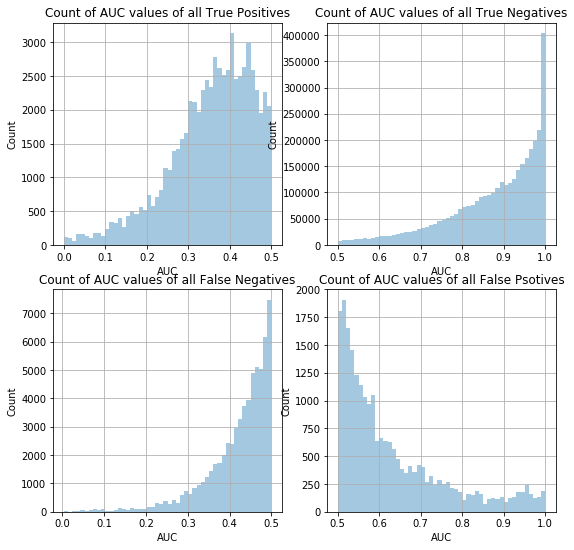

In [107]:
_, ax = plt.subplots(2,2,figsize=figsize)
ax = ax.ravel()

ax_0 = sns.distplot(prd_te_all[prd_te_all.scr=='TP'].AUC, bins=50, kde=False, ax=ax[0]);
ax_0.set_title('Count of AUC values of all True Positives')
ax_0.set_ylabel('Count');
ax_0.grid(True)

ax_1 = sns.distplot(prd_te_all[prd_te_all.scr=='TN'].AUC, bins=50, kde=False, ax=ax[1]);
ax_1.set_title('Count of AUC values of all True Negatives')
ax_1.set_ylabel('Count');
ax_1.grid(True)

ax_2 = sns.distplot(prd_te_all[prd_te_all.scr=='FN'].AUC, bins=50, kde=False, ax=ax[2]);
ax_2.set_title('Count of AUC values of all False Negatives')
ax_2.set_ylabel('Count');
ax_2.grid(True)

ax_3 = sns.distplot(prd_te_all[prd_te_all.scr=='FP'].AUC, bins=50, kde=False, ax=ax[3]);
ax_3.set_title('Count of AUC values of all False Psotives')
ax_3.set_ylabel('Count');
ax_3.grid(True)

In [105]:
# ax = sns.distplot(prd_te_all[prd_te_all.scr=='TP'].AUC, bins=50, kde=False);
# ax.set_title('Histogram of AUC values of all True Positives')
# ax.set_ylabel('Count');
# ax.grid(True)

In [104]:
# ax = sns.distplot(prd_te_all[prd_te_all.scr=='FN'].AUC, bins=50, kde=False);
# ax.set_title('Histogram of AUC values of all False Negatives')
# ax.set_ylabel('Count');
# ax.grid(True)

In [103]:
# ax = sns.distplot(prd_te_all[prd_te_all.scr=='TN'].AUC, bins=50, kde=False);
# ax.set_title('Histogram of AUC values of all True Negatives')
# ax.set_ylabel('Count');
# ax.grid(True)

In [102]:
# ax = sns.distplot(prd_te_all[prd_te_all.scr=='FP'].AUC, bins=50, kde=False);
# ax.set_title('Histogram of AUC values of all False Psotives')
# ax.set_ylabel('Count');
# ax.grid(True)

# Analyze pred probs

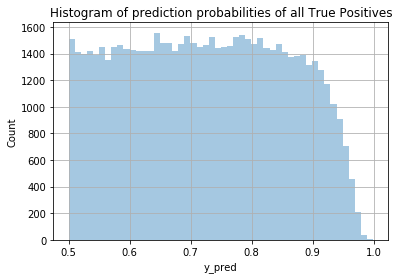

In [72]:
ax = sns.distplot(prd_te_all[prd_te_all.scr=='TP'].y_pred, bins=50, kde=False);
ax.set_title('Histogram of prediction probabilities of all True Positives')
ax.set_ylabel('Count');
ax.grid(True)

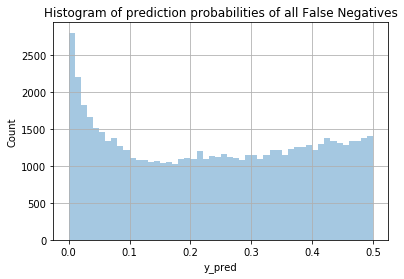

In [73]:
ax = sns.distplot(prd_te_all[prd_te_all.scr=='FN'].y_pred, bins=50, kde=False);
ax.set_title('Histogram of prediction probabilities of all False Negatives')
ax.set_ylabel('Count');
ax.grid(True)

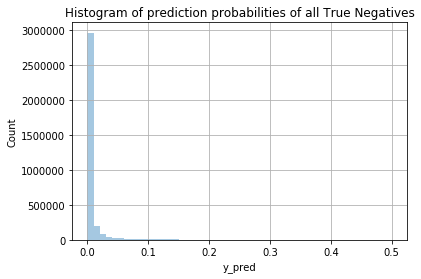

In [74]:
ax = sns.distplot(prd_te_all[prd_te_all.scr=='TN'].y_pred, bins=50, kde=False);
ax.set_title('Histogram of prediction probabilities of all True Negatives')
ax.set_ylabel('Count');
ax.grid(True)

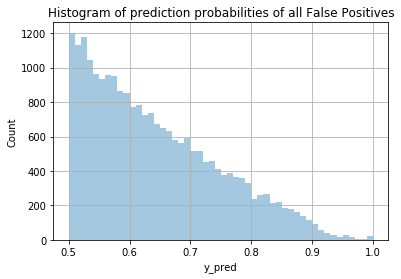

In [75]:
ax = sns.distplot(prd_te_all[prd_te_all.scr=='FP'].y_pred, bins=50, kde=False);
ax.set_title('Histogram of prediction probabilities of all False Positives')
ax.set_ylabel('Count');
ax.grid(True)

# Analyze pred probs vs AUC

### TP

In [92]:
figsize=(9,9)

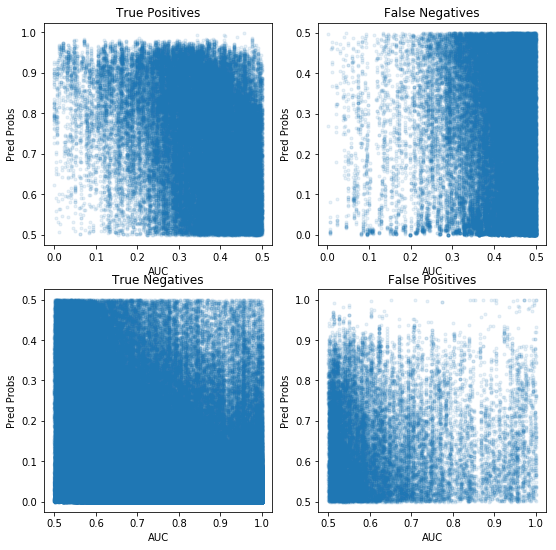

In [93]:
_, ax = plt.subplots(2, 2, figsize=figsize)
ax = ax.ravel()

df = prd_te_all[prd_te_all.scr=='TP']
ax[0].plot(df.AUC, df.y_pred, '.', alpha=0.1)
ax[0].set_title('True Positives')
ax[0].set_xlabel('AUC')
ax[0].set_ylabel('Pred Probs');

df = prd_te_all[prd_te_all.scr=='FN']
ax[1].plot(df.AUC, df.y_pred, '.', alpha=0.1)
ax[1].set_title('False Negatives')
ax[1].set_xlabel('AUC')
ax[1].set_ylabel('Pred Probs');

df = prd_te_all[prd_te_all.scr=='TN']
ax[2].plot(df.AUC, df.y_pred, '.', alpha=0.1)
ax[2].set_title('True Negatives')
ax[2].set_xlabel('AUC')
ax[2].set_ylabel('Pred Probs');

df = prd_te_all[prd_te_all.scr=='FP']
ax[3].plot(df.AUC, df.y_pred, '.', alpha=0.1)
ax[3].set_title('False Positives')
ax[3].set_xlabel('AUC')
ax[3].set_ylabel('Pred Probs');

# Filter samples

In [15]:
# Filter out samples with ambiguous true values
sm_dmp = sm[sm.y_true_unq_vals>1]
sm_flt = sm[sm.y_true_unq_vals==1]

print(sm_dmp.shape)
print(sm_flt.shape)

display(sm_flt)

(1487, 8)
(360205, 8)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CCLE.22RV1,CCLE.1,0,1,0.001621,0.000736,7,0
1,CCLE.22RV1,CCLE.10,0,1,0.001052,0.000662,8,0
2,CCLE.22RV1,CCLE.11,1,1,0.656640,0.063909,0,9
3,CCLE.22RV1,CCLE.12,0,1,0.001233,0.000346,13,0
4,CCLE.22RV1,CCLE.13,0,1,0.039151,0.013782,9,0
...,...,...,...,...,...,...,...,...
361687,gCSI.WM-266-4,gCSI.5,1,1,0.142768,0.016788,7,0
361688,gCSI.WM-266-4,gCSI.6,0,1,0.004280,0.001032,8,0
361689,gCSI.WM-266-4,gCSI.7,0,1,0.002990,0.000518,10,0
361690,gCSI.WM-266-4,gCSI.8,1,1,0.204251,0.049624,13,0


In [16]:
# Add columns of: TP, TN, FN, FP
sm_flt = add_conf_data(sm_flt)
display(sm_flt[:3])

# Prediction Analysis

In [1]:
# Groupby sample (cell-drug)

# sm = prd_te_to_grp.groupby(['CELL', 'DRUG']).agg(
#     {'CTYPE': np.unique,
#      'y_true': np.unique,
#      'y_true_unq_vals': np.unique,
#      'y_pred_prob_median': np.median,
#      'y_pred_prob_std': np.std,
#      'y_pred_cls_0': lambda x: int(sum(x)),
#      'y_pred_cls_1': lambda x: int(sum(x)),
#      }).reset_index()

# sm = reorg_ctype(sm)

# sm['y_true_unq_vals'] = sm.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
# display(sm[:3])

## Most confident predictions of responders

In [44]:
# Most confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

print('\nMost confident True Positives (correct predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa_[:n_show].reset_index(drop=True))

print('\nMost confident False Negatives (incorrect predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa_[:n_show].reset_index(drop=True))


Most confident True Positives (correct predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.697,CTRP.519,1,1,0.977059,0.034218,0,9,9,False,0,False
1,CTRP.697,CTRP.254,1,1,0.972207,0.026279,0,7,7,False,0,False
2,CCLE.697,CCLE.11,1,1,0.970869,0.006358,0,13,13,False,0,False
3,CTRP.GA-10,CTRP.519,1,1,0.970098,0.007729,0,9,9,False,0,False
4,CTRP.Mino,CTRP.519,1,1,0.968676,0.009850,0,12,12,False,0,False



Most confident False Negatives (incorrect predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.NCI-H209,GDSC.1005,1,1,0.000166,0.000821,11,0,0,False,11,False
1,CTRP.NCI-H209,CTRP.453,1,1,0.000309,0.020410,11,0,0,False,11,False
2,CTRP.PF-382,CTRP.274,1,1,0.000324,0.000176,13,0,0,False,13,False
3,CTRP.U-87-MG,CTRP.354,1,1,0.000365,0.000089,11,0,0,False,11,False
4,GDSC.OV-7,GDSC.1268,1,1,0.000442,0.000347,10,0,0,False,10,False


## Most confident predictions of non-responders

In [41]:
# Most confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
bb = sm_flt[sm_flt.y_true==rsp_value]

print('\nMost confident True Negatives (correct predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=True)
display(bb_[:n_show].reset_index(drop=True))

print('\nMost confident False Positives (incorrect predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=False)
display(bb_[:n_show].reset_index(drop=True))


Most confident True Negatives (correct predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.ONCO-DG-1,CTRP.5,0,1,0.000057,0.000086,4,0,False,4,False,0
1,NCI60.HCT-15,NSC.521778,0,1,0.000059,0.000124,7,0,False,7,False,0
2,CTRP.SW-1353,CTRP.429,0,1,0.000069,0.000067,3,0,False,3,False,0
3,NCI60.MDA-MB-231,NSC.521778,0,1,0.000070,0.000060,12,0,False,12,False,0
4,NCI60.UACC-257,NSC.130181,0,1,0.000071,0.000051,11,0,False,11,False,0



Most confident False Positives (incorrect predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.GA-10,GDSC.1004,0,1,0.933688,0.012529,0,11,False,0,False,11
1,GDSC.RS4-11,GDSC.104,0,1,0.933624,0.013963,0,7,False,0,False,7
2,gCSI.MOLP-8,gCSI.2,0,1,0.930718,0.016131,0,13,False,0,False,13
3,gCSI.A2780,gCSI.13,0,1,0.923437,0.016109,0,11,False,0,False,11
4,GDSC.BV-173,GDSC.201,0,1,0.918663,0.018618,0,7,False,0,False,7


## Least confident True Positives

In [52]:
# Least confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident True Positives (correct predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident True Positives (correct predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.NCI-H2444,GDSC.268,1,1,0.500021,0.042043,5,5,5,False,5,False
1,CTRP.NCI-H522,CTRP.3,1,1,0.500059,0.060187,4,4,4,False,4,False
2,CTRP.RH-41,CTRP.259,1,1,0.500100,0.051694,6,7,7,False,6,False
3,CTRP.NCI-H1373,CTRP.309,1,1,0.500414,0.044360,4,5,5,False,4,False
4,GDSC.BV-173,GDSC.87,1,1,0.500514,0.080535,4,4,4,False,4,False


## Least confident False Positives

In [53]:
# Least confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident False Positives (incorrect predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident False Positives (incorrect predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.OS-RC-2,GDSC.1007,0,1,0.500045,0.079234,6,6,False,6,False,6
1,CTRP.Hs-944-T,CTRP.182,0,1,0.500135,0.060915,3,3,False,3,False,3
2,GDSC.RKO,GDSC.283,0,1,0.500389,0.044531,6,6,False,6,False,6
3,CTRP.COLO-741,CTRP.413,0,1,0.500416,0.061832,5,6,False,5,False,6
4,gCSI.KALS-1,gCSI.4,0,1,0.500451,0.068223,4,6,False,4,False,6


## Least confident False Negatives

In [54]:
# Least confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident False Negatives (incorrect predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident False Negatives (incorrect predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.LCLC-97TM1,CTRP.363,1,1,0.499883,0.045485,3,3,3,False,3,False
1,GDSC.OCI-M1,GDSC.11,1,1,0.499847,0.121931,4,3,3,False,4,False
2,CTRP.EM-2,CTRP.196,1,1,0.499691,0.066222,6,6,6,False,6,False
3,CTRP.MOLT-13,CTRP.513,1,1,0.499662,0.048934,4,4,4,False,4,False
4,GDSC.Hs-683,GDSC.140,1,1,0.499661,0.056749,5,4,4,False,5,False


## Least confident True Negatives

In [55]:
# Least confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident True Negatives (correct predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident True Negatives (correct predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,NCI60.CCRF-CEM,NSC.755387,0,1,0.499984,0.048585,11,10,False,11,False,10
1,GDSC.NCI-H2405,GDSC.201,0,1,0.499969,0.042876,5,5,False,5,False,5
2,CTRP.NCI-H1105,CTRP.3,0,1,0.499773,0.033665,3,3,False,3,False,3
3,GDSC.MCAS,GDSC.140,0,1,0.499625,0.065358,4,4,False,4,False,4
4,GDSC.NCI-H1836,GDSC.201,0,1,0.499593,0.071260,5,5,False,5,False,5
